The data files are zipped in the file datafiles.zip. Where the data is used below, references are made to the origin of that dataset, as well as any modifications that have been done locally.

Manage imported libraries

In [2]:
import csv
from os import listdir
from os.path import isfile, join
import geopandas as gpd
import pandas as pd
import shapely
from matplotlib.pyplot import figure
import numpy as np
from scipy import ndimage

import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
pylab.rcParams['figure.figsize'] = 8, 6

Read in geojson data to geopandas dataframes

In [3]:
census_income_data = gpd.read_file('census-tracts-2000.geojson')
neighborhoods = gpd.read_file('community-areas.geojson')

For sanity, display headers for the GPD dataframes

In [4]:
print(census_income_data.head())

  tract_cens tract_fips     shape_area perimeter        tract_cent  \
0       2000      17031  11228197.5722       0.0  1160171.70454335   
1       2000      17031  20199335.5566       0.0  1169816.30242459   
2       2000      17031  3170252.61205       0.0   1166814.1830406   
3       2000      17031  9690785.77117       0.0  1157599.24855614   
4       2000      17031  8038189.85397       0.0  1165053.80574048   

    census_t_1 tract_numa tract_comm objectid tract_cr_1 data_admin  \
0  17031720500         36         72        1       None        0.0   
1  17031730200        113         73        2       None        0.0   
2  17031730300         22         73        3       None        0.0   
3  17031740100         45         74        4       None        0.0   
4  17031710500         33         71        5       None        0.0   

         tract_ce_1 census_tra   tract_ce_3 tract_crea    tract_ce_2  \
0   1834962.2944345     720500  41.70283387             -87.68910702   
1  18437

In [5]:
print(neighborhoods.head())

         community area     shape_area perimeter area_num_1 area_numbe  \
0          DOUGLAS    0  46004621.1581         0         35         35   
1          OAKLAND    0  16913961.0408         0         36         36   
2      FULLER PARK    0  19916704.8692         0         37         37   
3  GRAND BOULEVARD    0  48492503.1554         0         38         38   
4          KENWOOD    0  29071741.9283         0         39         39   

  comarea_id comarea      shape_len  \
0          0       0  31027.0545098   
1          0       0  19565.5061533   
2          0       0  25339.0897503   
3          0       0  28196.8371573   
4          0       0  23325.1679062   

                                            geometry  
0  (POLYGON ((-87.60914087617894 41.8446925026539...  
1  (POLYGON ((-87.59215283879394 41.8169293462668...  
2  (POLYGON ((-87.62879823733725 41.8018930336891...  
3  (POLYGON ((-87.6067081256125 41.81681377057218...  
4  (POLYGON ((-87.59215283879394 41.816929346

Read in the 2000 median household income data and prepare it for conversion to pandas dataframe. While other data is from either 2010, the most recently-provided MHI data is from 2000, hence the discrepency.

Household income data was derived from a PDF file from the City of Chicago (https://www.chicago.gov/content/dam/city/depts/doit/general/GIS/Chicago_Maps/Census_Maps/Income_MedianHousehold.pdf, a copy included in the github repo), colors read in via Gimp, and manually mapped to census blocks defined in a shapefile (https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Census-Tracts-2000/pt6c-hxpp), also from the City of Chicago.

In [6]:
with open("sorted-census-tract-median-household-income.csv", "r") as tract_income:
    tract_income_list = list(csv.DictReader(tract_income))

Convert the household income data into a pandas dataframe and merge it into the tract GPD dataframe

In [7]:
tract_info_df = pd.DataFrame(tract_income_list)
with_incomes = pd.merge(census_income_data, tract_info_df, on="census_tra")

In [8]:
print(with_incomes.head())

  tract_cens tract_fips     shape_area perimeter        tract_cent  \
0       2000      17031  11228197.5722       0.0  1160171.70454335   
1       2000      17031  20199335.5566       0.0  1169816.30242459   
2       2000      17031  3170252.61205       0.0   1166814.1830406   
3       2000      17031  9690785.77117       0.0  1157599.24855614   
4       2000      17031  8038189.85397       0.0  1165053.80574048   

    census_t_1 tract_numa tract_comm objectid tract_cr_1 data_admin  \
0  17031720500         36         72        1       None        0.0   
1  17031730200        113         73        2       None        0.0   
2  17031730300         22         73        3       None        0.0   
3  17031740100         45         74        4       None        0.0   
4  17031710500         33         71        5       None        0.0   

         tract_ce_1 census_tra   tract_ce_3 tract_crea    tract_ce_2  \
0   1834962.2944345     720500  41.70283387             -87.68910702   
1  18437

Plot the city map, colorized by income range, and overlay with the outlines of named neighborhoods (https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Neighborhoods/bbvz-uum9).

Read in crime data (https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2), filtered to just crimes in 2010-2011.

I'm not really happy with how I've read in the crimes dataset, but so far, it's the only way I've figured out to get the GPS coordinates properly added to be used farther down when the data is in the geopandas DataFrame.

In [9]:
ids = []
date = []
ptype = []
desc = []
locdesc = []
arrest = []
community_area = []
geometry = []

# Read in the two chunks of the CPD crimes dataset, which was broken up
# to fit into the GitHub 100MB/file limit
chunkfiles: list = ['crimes-2010-2011-0.csv', 'crimes-2010-2011-1.csv']

for chunk in chunkfiles:
    with open(chunk, "r") as crimes_fh:
        for row in crimes_fh:
            if "IUCR" in row or '"(41' not in row:
                # Ignore the header row and rows missing GPS coordinates
                continue
            else:
                row = row.replace(',,',',<empty>,').replace(')"','').rstrip()
                row = row.lstrip('"(')
                fields = row.split(',')
                ids.append(fields[0])
                date.append(fields[2].split(' ')[0])
                ptype.append(fields[5])
                desc.append(fields[6])
                locdesc.append(fields[7])
                arrest.append(fields[8])
                community_area.append(fields[9])
                lat = float(fields[-3].lstrip('"('))
                lon = float(fields[-4].rstrip(')"'))
                geometry.append(shapely.geometry.point.Point(lat, lon))

In [10]:
data = {
'date': pd.Series(date, index=ids),
"primary type": pd.Series(ptype, index=ids),
"description": pd.Series(desc, index=ids),
"location description": pd.Series(locdesc, index=ids),
"arrest": pd.Series(arrest, index=ids),
"community area": pd.Series(community_area, index=ids),
"geometry": pd.Series(geometry, index=ids)   
     }

In [11]:
crimes = gpd.GeoDataFrame(data, index=ids)

These are the absolute bounds of the crimes dataset's GPS coordinates

In [12]:
crimes_minx = crimes['geometry'].bounds['minx'].min()
crimes_miny = crimes['geometry'].bounds['miny'].min()
crimes_maxx = crimes['geometry'].bounds['maxx'].min()
crimes_maxy = crimes['geometry'].bounds['maxy'].min()

In [13]:
print(crimes_minx)
print(crimes_miny)
print(crimes_maxx)
print(crimes_maxy)

-87.927881741
41.644589713
-87.927881741
41.644589713


And these are the absolute bounds of the Chicago map, based on the community_names dataset

In [14]:
neighborhoods_minx = neighborhoods.bounds['minx'].min()
neighborhoods_miny = neighborhoods.bounds['miny'].min()
neighborhoods_maxx = neighborhoods.bounds['maxx'].min()
neighborhoods_maxy = neighborhoods.bounds['maxy'].min()

In [15]:
print(neighborhoods_minx)
print(neighborhoods_miny)
print(neighborhoods_maxx)
print(neighborhoods_maxy)

-87.9401140825235
41.644543121506054
-87.83479485589937
41.685433883167434


Generate the first map, showing the median household income data by census tract, overlayed with the borders of the named Chicago neighborhoods.

My intent is to eventually overlay this map with the crimes data, but that's not working yet.

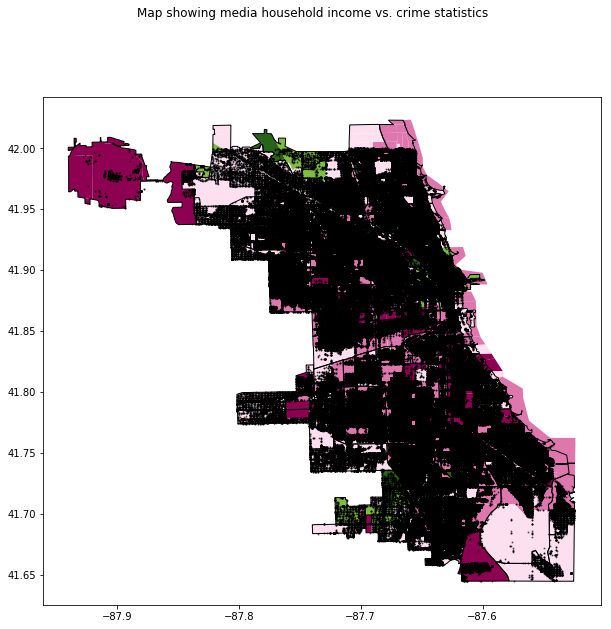

In [16]:
fig, ax = plt.subplots()
fig.suptitle('Map showing media household income vs. crime statistics')
ax.set_aspect('equal')
fig.set_size_inches(10,10)
with_incomes.plot(ax=ax, column="income_range",  cmap='PiYG')
neighborhoods.plot(ax=ax, edgecolor='black', color='none')
crimes.plot(ax=ax, color='black', marker='o', markersize=1, alpha=.5)
plt.show()

In [17]:
def getx(pt):
    return pt.coords[0][0]

def gety(pt):
    return pt.coords[0][1]

In [18]:
x = list(crimes.geometry.apply(getx))
y = list(crimes.geometry.apply(gety))
heatmap, xedges, yedges = np.histogram2d(y, x, bins=(100,100))
extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]

In [19]:
logheatmap = np.log(heatmap)
logheatmap[np.isneginf(logheatmap)] = 0
logheatmap = ndimage.filters.gaussian_filter(logheatmap, 1.3, mode='nearest')

/Users/jon/anaconda3/envs/geospatial/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


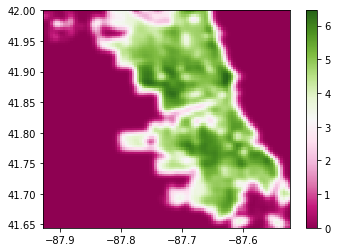

In [20]:
plt.imshow(logheatmap, cmap="PiYG", extent=extent)
plt.colorbar()
plt.gca().invert_yaxis()
plt.show()

In [1]:
def heatmap(d, bins=(100,100), smoothing=1.3, cmap='jet'):
    def getx(pt):
        return pt.coords[0][0]

    def gety(pt):
        return pt.coords[0][1]

    x = list(d.geometry.apply(getx))
    y = list(d.geometry.apply(gety))
    heatmap, xedges, yedges = np.histogram2d(y, x, bins=bins)
    extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]

    logheatmap = np.log(heatmap)
    logheatmap[np.isneginf(logheatmap)] = 0
    logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')
    
    plt.imshow(logheatmap, cmap="PiYG", extent=extent)
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.show()

In [2]:
heatmap(crimes, bins=50, smoothing=1.5)

NameError: name 'crimes' is not defined

Below this point are cells I used for testing to understand better how the various bits fit together

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world['centroid_column'] = world.centroid
print(world.head())
type(world.iloc[0]['centroid_column'])